# Text Mining DocSouth Slave Narrative Archive
---

*Note:* This is the first in [a series of documents and notebooks](https://jeddobson.github.io/textmining-docsouth/) that will document and evaluate various machine learning and text mining tools for use in literary studies. These notebooks form the practical and critical archive of my book-in-progress, _Digital Humanities and the Search for a Method_. I have published a critique of some existing methods (Dobson 2015) that takes up some of these concerns and provides some theoretical background for my account of computational methods as used within the humanities. Each notebook displays code, data, results, interpretation, and critique. I attempt to provide as much explanation of the individual steps and documentation (along with citations of related papers) of the concepts and justification of choices made.   

### Revision Date and Notes:

- 05/10/2017: Initial version (james.e.dobson@dartmouth.edu)
- 08/29/2017: Updated to automatically assign labels and reduced to two classes/periods.

### KNearest Neighbor (kNN) period classification of texts

The following Jupyter cells show a very basic classification task using the [kNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) algorithm as implemented in Python and with the [scikit-learn](http://scikit-learn.org/) package.

A simple check to see if the dates in the table of contents ("toc.csv") for the DocSouth ["North American Slave Narratives"](http://docsouth.unc.edu/neh/) can be converted to an integer (date as year) is used to assign one of these two classes:

- antebellum: prior to 1865
- postbellum: after 1865 

These period categories are rough and by no means not perfect. Publication year may have little relation to the content of the text, the source for the vectorizing process and eventual categorization. These dates are what Matthew Jockers calls, within the digital humanities context, catalog metadata (Jockers 2013, 35-62). Recently, critics have challenged such divisions (Marrs 2015) that are central to the understanding of field of nineteenth-century American literary studies with concepts like "transbellum" that might be capable of helping to better understand works that address the Civil War and its attendant anxities through the "long nineteenth century." The majority of the texts included in the DocSouth archive are first-person autobiographical narratives of lives lived during the antebellum and Civil War years and published in the years leading up to, including, and after the war.

### Complete (Labeled) Dataset

|class|count|
|---|---|
|antebellum|143|
|postbellum|109|
|unknown or ambiguous|40|

There are 252 texts with four digit years and eighteen texts with ambiguous or unknown publication dates. This script will attempt to classify these texts into one of these two periods following the "fitting" of the labeled training texts. I split the 252 texts with known and certain publication dates into two groups: a training set and a testing test. After "fitting" the training set and establishing the neighbors, the code attempts to categorize the testing set. Many questions can and should be asked about the creation of the training set and the labeling of the data. This labeling practice introduces many subjective decisions into what is perceived as an objective (machine and algorithmically generated) process (Dobson 2015, Gillespie 2016).

### Training Data Set

The training set (the first 252 texts, preserving the order in "toc.csv") over-represents the antebellum period and may account for the ability of the classifier to make good predictions for this class. 

|class|count|
|---|---|
|antebellum|96|
|postbellum|81|

### Test Data Set

The "testing" dataset is used to validate the classifier. This dataset contains seventy-five texts with known year of publication. This dataset, like the training dataset, overrepresents the antebellum period.

|class|count|
|---|---|
|antebellum|47|
|postbellum|28|




#### Text Pre-processing

The texts are all used/imported as found in the zip file provided by the DocSouth ["North American Slave Narratives"](http://docsouth.unc.edu/neh/) collection. The texts have been encoded in a combination of UTF-8 Unicode and ASCII. Scikit-learn's HashingVectorizer performs some additional pre-processing and that will be examined in the sections below. 

#### kNN Background

The kNN algorithm is a non-parametric algorithm, meaning that it does not require detailed knowledge of the input data and its distribution (Cover and Hart 1967). This algorithm is known as reliable and it is quite simple, especially when compared to some of the more complex machine learning algorithms used as present, to implement and understand. It was originally conceived of as a response to what is called a “discrimination problem”: the categorization of a large number of input points into discrete "boxes." Data are eventually organized into categories, in the case of this script, the three categories of antebellum, postbellum, and twentieth-century. 

The algorithm functions in space and produces each input text as a "neighbor" and has each text "vote" for membership into parcellated neighborhoods. Cover and Hart explain: "If the number of samples is large it makes good sense to use, instead of the single nearest neighbor, the majority vote of the nearest k neighbors" (22). The following code uses the value of "12" for the number of neighbors or the 'k' of kNN.

The kNN algorithm may give better results for smaller numbers of classes. The performance of particular implementation of kNN and the feature selection algorithm (HashingVectorizer) was better with just the antebellum and postbellum class. Alternative boundaries for the classes (year markers) might also improve results.

#### Feature Selection

While it is non-parametics, the kNN algorithm does require a set of features in order to categorize the input data, the texts. This script operates according to the _"bag of words"_ method in which each text is treated not as a narrative but a collection of unordered and otherwise undiferentiated words. This means that multiple word phrases (aka ngrams) are ignored and much meaning will be removed from the comparative method because of a loss of context. 

In order to select the features by which a text can be compared to another, we need some sort of method that can produce numerical data. I have selected the HashingVectorizer, which is a fast method to generate a list of words/tokens from a file. This returns a numpy compressed sparse row (CSR) matrix that scikit-learn will use in the creation of the neighborhood "map." 

The HashingVectorizer removes a standard 318 English-language stop words and by default does not alter or remove any accents or accented characters in the encoded (UTF-8) format. It also converts all words to lowercase, potentially introducing false positives. 

**Issues with HashingVectorizer** This vectorizer works well, but it limits the questions we can ask after it has been run. We cannot, for example, interrogate why a certain text might have been misclassified by examining the words/tokens returned by the vectorizer. This is because the HashingVectorizer returns only indices to features and does not keep the string representation of specific words. 

In [1]:
# load required packages
import sys, os
import re
import operator
import nltk

from nltk import pos_tag, ne_chunk
from nltk.tokenize import wordpunct_tokenize

import seaborn as sn
%matplotlib inline

In [2]:
# load local library
sys.path.append("lib")
import docsouth_utils

In [3]:
# each dictionary entry in the 'list' object returned by load_narratives 
# contains the following keys:
#  'author' = Author of the text (first name, last name)
#  'title' = Title of the text
#  'year' = Year published as integer or False if not simple four-digit year
#  'file' = Filename of text
#  'text' = NLTK Text object

neh_slave_archive = docsouth_utils.load_narratives()

In [4]:
# establish two simple classes for kNN classification
# the "date" field has already been converted to an integer
# all texts published before 1865, we'll call "antebellum"
# "postbellum" for those after.

period_classes=list()

for entry in neh_slave_archive:
    file = ' '.join(entry['text'])
    if entry['year'] != False and entry['year'] < 1865:
        period_classes.append([file,"antebellum"])
    if entry['year'] != False and entry['year'] > 1865:  
        period_classes.append([file,"postbellum"])

# create labels and filenames      
labels=[i[1] for i in period_classes]
files=[i[0] for i in period_classes]

# create training and test datasets by leaving out the
# last 100 files with integer dates from the toc for testing.

test_size=100

train_labels=labels[:-test_size]
train_files=files[:-test_size]

# the last set of texts (test_size) are the "test" dataset (for validation)
test_labels=labels[-test_size:]
test_files=files[-test_size:]

In [5]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# intialize the vectorizer using occurance counts normalized as 
# token frequencies: norm=l2
vectorizer = HashingVectorizer(lowercase=True,
                               stop_words='english',
                               norm='l2',  
                               non_negative=True)

training_data = vectorizer.fit_transform(train_files)
test_data=vectorizer.transform(test_files)

In [6]:
# display file counts
print("training data:")
for period in ['postbellum', 'antebellum']:
    print(" ",period,":",train_labels.count(period))
print("test data:")
for period in ['postbellum', 'antebellum']:
    print(" ",period,":",test_labels.count(period))

training data:
  postbellum : 77
  antebellum : 75
test data:
  postbellum : 32
  antebellum : 68


In [7]:
# run kNN and fit training data
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(training_data,train_labels)

# Predict results from the test data and check accuracy
pred = knn.predict(test_data)
score = metrics.accuracy_score(test_labels, pred)
print("accuracy:   %0.3f" % score)
print(metrics.classification_report(test_labels, pred))
print("confusion matrix:")
print(metrics.confusion_matrix(test_labels, pred))

accuracy:   0.800
             precision    recall  f1-score   support

 antebellum       0.88      0.82      0.85        68
 postbellum       0.67      0.75      0.71        32

avg / total       0.81      0.80      0.80       100

confusion matrix:
[[56 12]
 [ 8 24]]


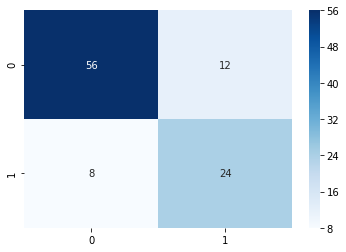

In [8]:
# Produce visualization of confusion matrix
sn.heatmap(metrics.confusion_matrix(test_labels, pred),annot=True,cmap='Blues',fmt='g')

## Prediction of unclassified data
The following cell loads and vectorizes (using the above HashingVectorizing method, with the exact same parameters used for the training set) and tests against the trained classifier, all the algorithmically uncategorized and ambiguously dated (in the toc.csv) input files. 

### Partial list of Unspecified or Ambiguous Publication Dates


|File|Date|
|---|---|
|church-hatcher-hatcher.txt|c1908|
|fpn-jacobs-jacobs.txt|1861,c1860
|neh-aga-aga.txt|[1846]|
|neh-anderson-anderson.txt|1854?|
|neh-brownj-brownj.txt|1856,c1865
|neh-carolinatwin-carolinatwin.txt|[between 1902 and 1912]|
|neh-delaney-delaney.txt|[189?]|
|neh-equiano1-equiano1.txt|[1789]|
|neh-equiano2-equiano2.txt|[1789]|
|neh-henry-henry.txt|[1872]|
|neh-jonestom-jones.txt|[185-?]|
|neh-latta-latta.txt|[1903]|
|neh-leewilliam-lee.txt|c1918|
|neh-millie-christine-millie-christine.txt|[18--?]|
|neh-parkerh-parkerh.txt|186?|
|neh-pomp-pomp.txt|1795|
|neh-washstory-washin.txt|c1901|
|neh-white-white.txt|[c1849]|

In [9]:
# predict class or period membership for all texts without
# four digit years
for entry in neh_slave_archive:
    if entry['year'] == False:
        print(entry['author'],", ",entry['title'])
        print("   ",knn.predict(vectorizer.transform([entry['file']])))

William S. White ,  The African Preacher. An Authentic Narrative
    ['postbellum']
Henry  Parker ,  Autobiography of Henry Parker
    ['antebellum']
Thomas W. Henry ,  Autobiography of Rev. Thomas W. Henry, of the A. M. E. Church
    ['antebellum']
Booker T. Washington ,  An Autobiography: The Story of My Life and Work
    ['antebellum']
  No Author ,  Biographical Sketch of Millie Christine, the Carolina Twin, Surnamed the Two-Headed Nightingale and the Eighth Wonder of the World
    ['antebellum']
Josephine  Brown ,  Biography of an American Bondman, by His Daughter
    ['antebellum']
  Pomp ,  Dying Confession of Pomp, A Negro Man, Who Was Executed at Ipswich, on the 6th August, 1795, for Murdering Capt. Charles Furbush, of Andover, Taken from the Mouth of the Prisoner, and Penned by Jonathan Plummer, Jun.
    ['antebellum']
Thomas H. Jones ,  Experience and Personal Narrative of Uncle Tom Jones; Who Was for Forty Years a Slave. Also the Surprising Adventures of Wild Tom, of the Is

## Works Cited

Cover T.M. and P. E. Hart. 1967. "Nearest Neighbor Pattern Classification." _IEEE Transactions on Information Theory_ 13, no. 1: 21-27.

Dobson, James E. 2015. [“Can an Algorithm be Disturbed? Machine Learning, Intrinsic Criticism, and the Digital Humanities.”](https://mla.hcommons.org/deposits/item/mla:313/) _College Literature_ 42, no. 4: 543-564. 

Gillespie, Tarleton. 2016. “Algorithm.” In _Digital Keywords: A Vocabulary of Information Society and Culture_. Edited by Benjamin Peters. Princeton: Princeton University Press.

Jockers, Matthew. 2013. _Macroanalysis: Digital Methods & Literary History_ Urbana: University of Illinois Press.

Marrs, Cody. 2015. _Nineteenth-Century American Literature and the Long Civil War_. New York: Cambridge University Press.
